<a href="https://colab.research.google.com/github/PDDA-OPDU/MICP-Analytics/blob/main/Gaussian_GEV_CDF_PDF_nosort/GenExtremeValue_CDF_PDF_distributions_nosort.ipynb" 
    target="_parent"><img 
    src="https://colab.research.google.com/assets/colab-badge.svg" 
    alt="Open In Colab"/></a>

In [1]:
using_colab = False

In [2]:
if using_colab:


    !wget 'https://github.com/PDDA-OPDU/MICP-Analytics/raw/main/Gaussian_GEV_CDF_PDF_nosort/CORE_DATA_AND_DESCRIPTIONS_DATABASE_HPMI.xlsx'
    #!wget 'https://github.com/Philliec459/Open-Source-Petrophysics/raw/main/photos.ZIP'

    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/STELLA_brief_ver2_backyard_grass_shoreline.ipynb
    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/data_white_grass_shade_whiteshade.xlsx
    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/data_white_FullSun.xlsx

    #!pip install altair
    #!pip install panel
    #!pip install pillow
    #!pip install jupyter_bokeh
    #!pip install altair_viewer
    #!pip install altair_transform
    !pip install scipy

    #!unzip photos


# Load Phython libraries:

In [3]:
import warnings
warnings.filterwarnings("ignore")


import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt
import os

import seaborn as sns

from sklearn.metrics import r2_score

from scipy.stats import genextreme


# Load Data

## The following cells will load the Kansas Geologic Survey HPMI data from an Excel spreadsheet.


## 1) Load row of HPMI data starting at row A12:A130 for Pc and xxx12 to xxx130 for Sw

In [4]:
# Function to convert a number to an Excel-style column letter (supports beyond Z)
def get_column_letter(n):
    result = ""
    while n > 0:
        n, remainder = divmod(n - 1, 26)
        result = chr(65 + remainder) + result
    return result

# Specify the file path and sheet number
file_path = 'CORE_DATA_AND_DESCRIPTIONS_DATABASE_HPMI.xlsx'
sheet_number = 0  # Second sheet, as pandas uses zero-indexing

# Read the Pc values (same for all samples)
pc_values = pd.read_excel(file_path, sheet_name=sheet_number, usecols="A", skiprows=11, nrows=119)

# Initialize a dictionary to store data for each sample
data_dict = {}

# Loop through each sample (from column B onward)
# Adjust the range according to the number of samples we need to process
for sample_num in range(1, 36):  # Example for 51 samples, adjust as necessary
    column_letter = get_column_letter(sample_num + 1)  # +1 because 'B' is column 2
    #print(f"Processing sample {sample_num} (Column {column_letter})")

    # Read Sw values for the current sample
    sw_values = pd.read_excel(file_path, sheet_name=sheet_number, usecols=column_letter, skiprows=11, nrows=119)
    
    # Read Porosity for the current sample (assumed to be in row 8)
    porosity = pd.read_excel(file_path, sheet_name=sheet_number, usecols=column_letter, skiprows=7, nrows=1).iloc[0, 0]
    
    # Read Permeability for the current sample (assumed to be in row 9)
    permeability = pd.read_excel(file_path, sheet_name=sheet_number, usecols=column_letter, skiprows=8, nrows=1).iloc[0, 0]

    # Read Num of Pore systems for the current sample (assumed to be in row 10)
    Num_pore_sys = pd.read_excel(file_path, sheet_name=sheet_number, usecols=column_letter, skiprows=9, nrows=1).iloc[0, 0]
    #print(Num_pore_sys)

    # Store the data in the dictionary
    data_dict[f'Sample_{sample_num}'] = {
        'Pc': pc_values.values.flatten(),
        'Sw': sw_values.values.flatten(),
        'Porosity (%)': porosity,
        'Permeability': permeability,
        'Num_pore_sys': Num_pore_sys,
    }

# Now, data_dict contains the data for all samples, structured for easy access
#print(data_dict)

# Batch 1, 2, or 3 from the spreadsheet
Pc_batch = 1


# Auto Optimization - no sorting of GEV fit parameters: 

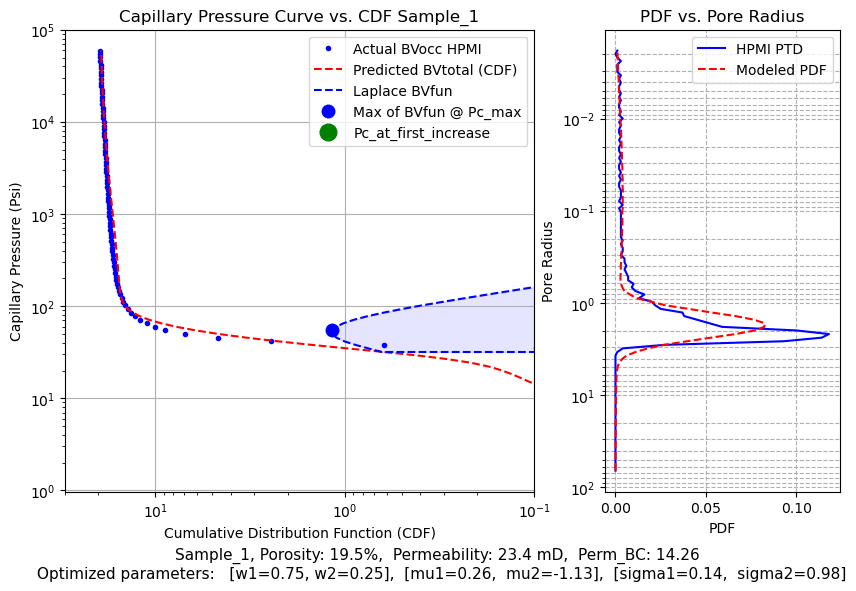

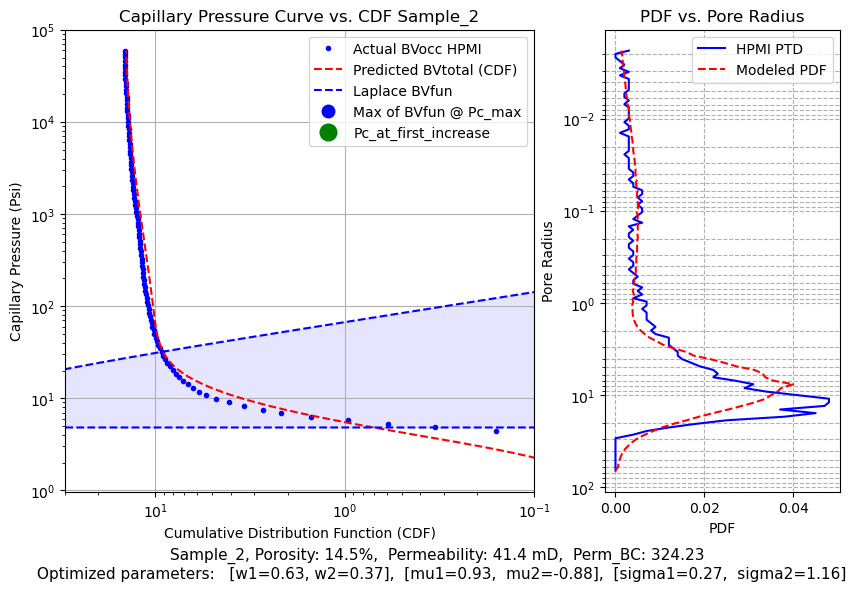

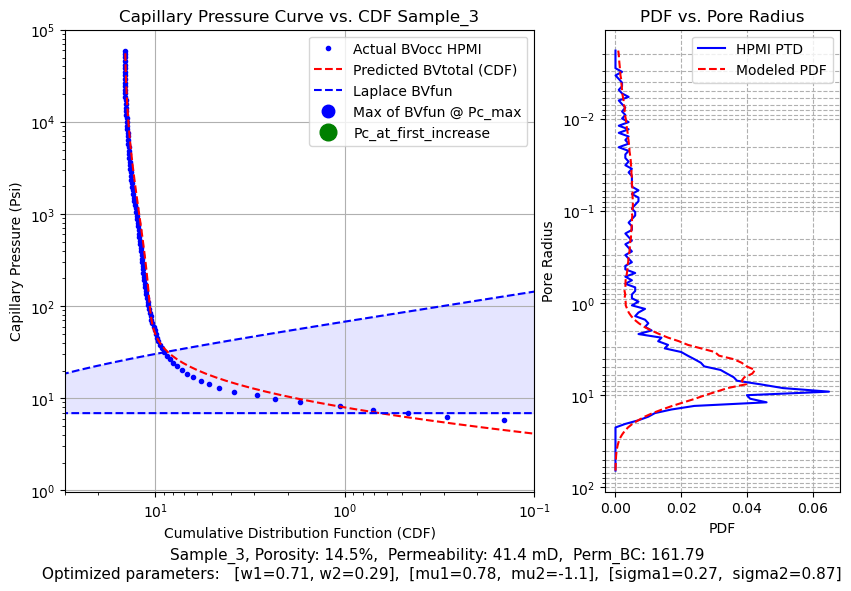

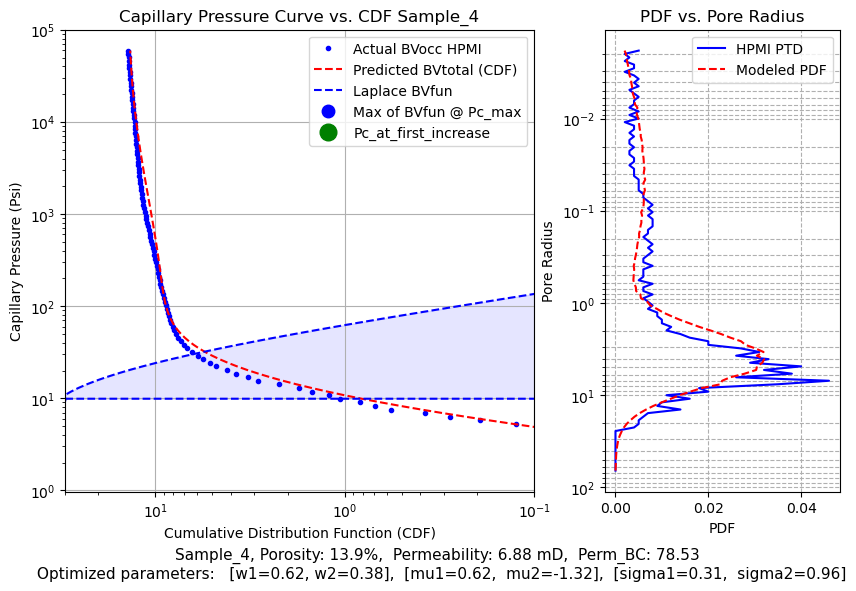

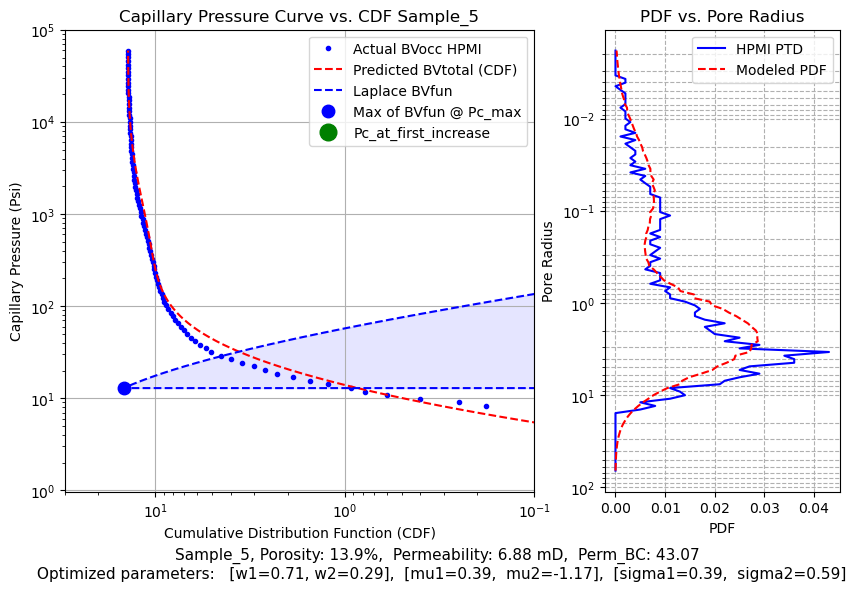

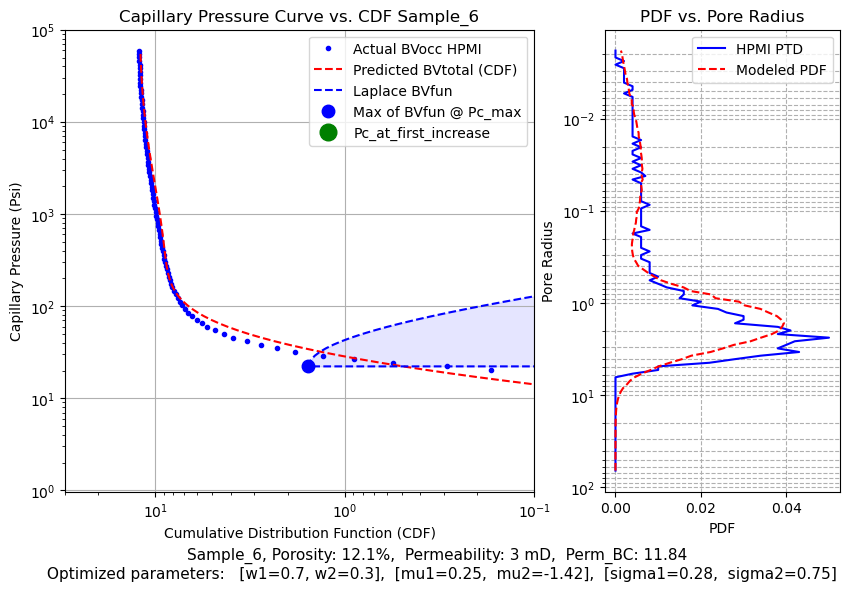

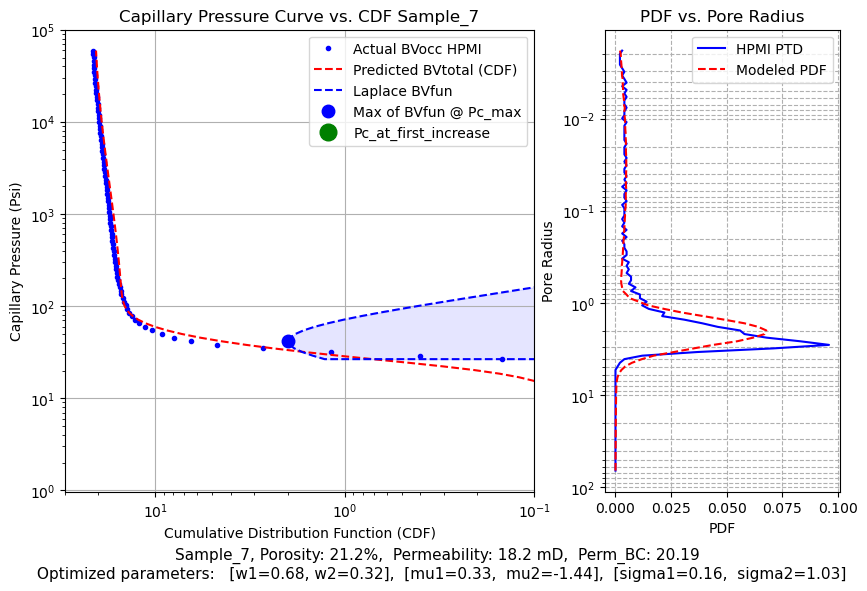

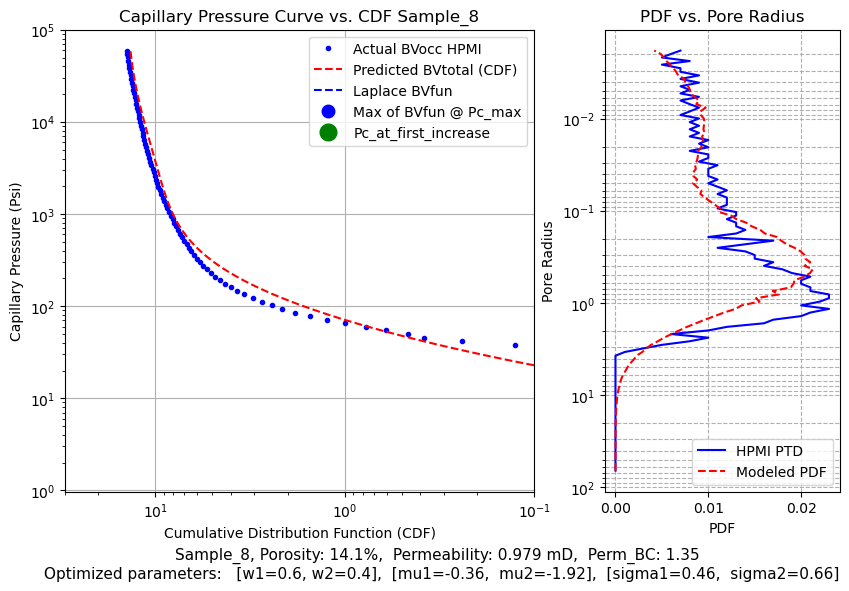

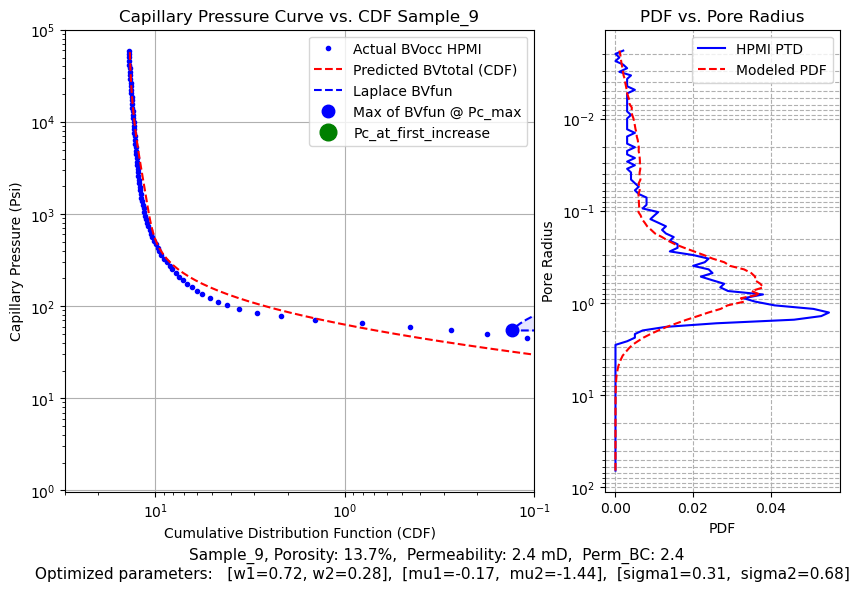

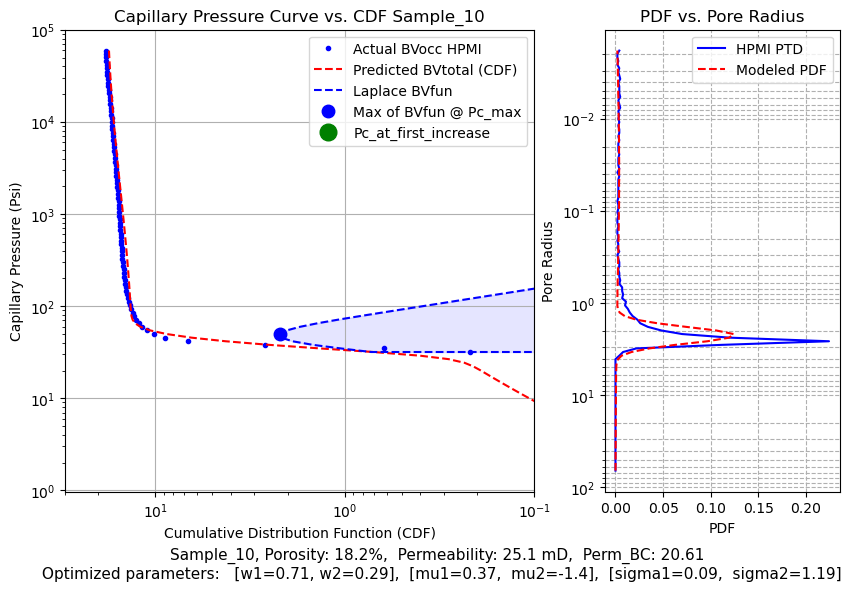

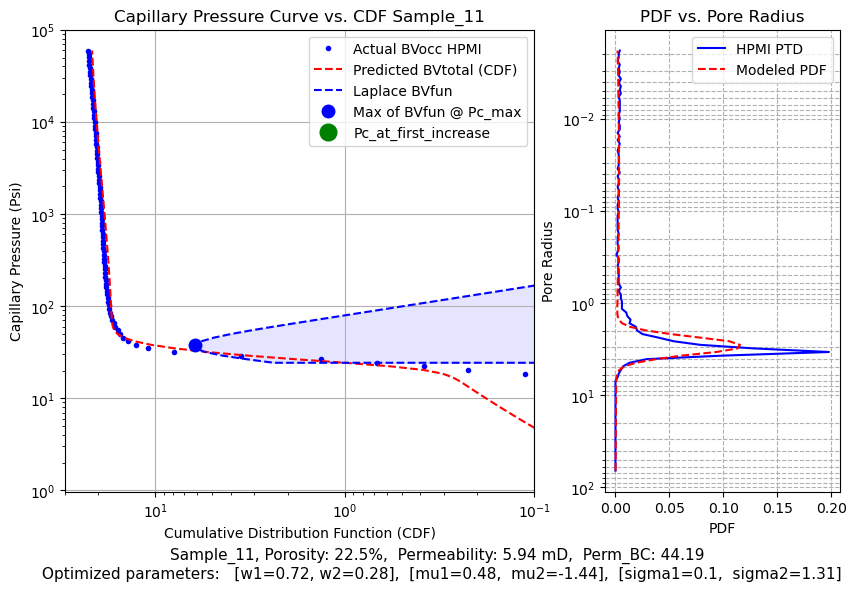

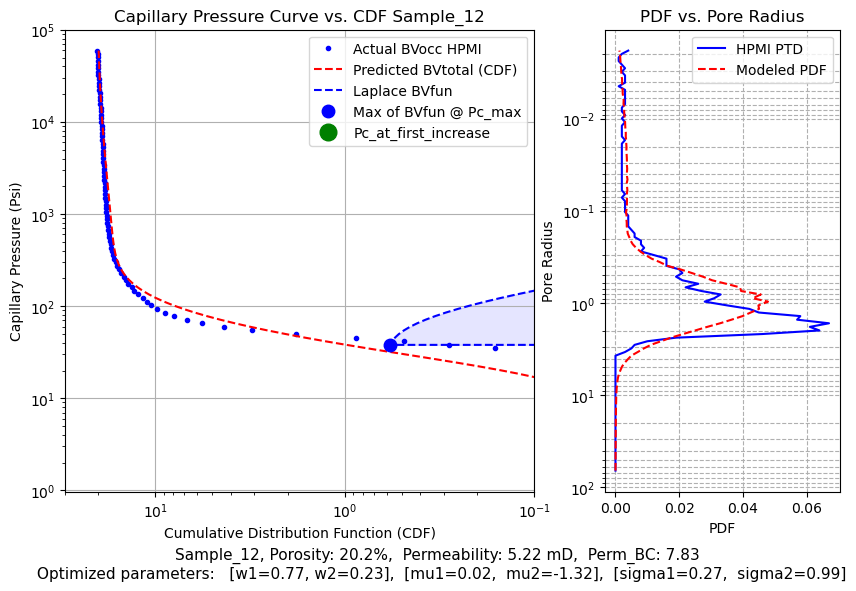

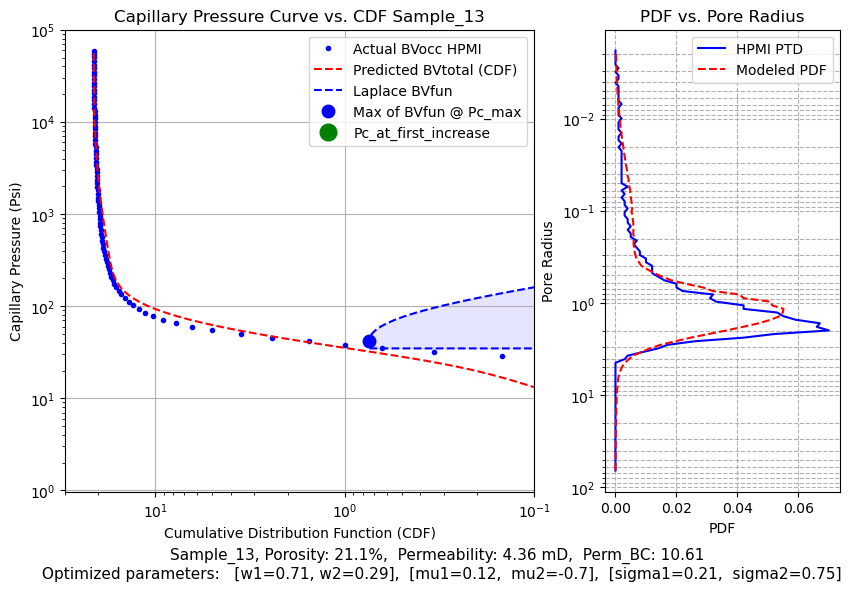

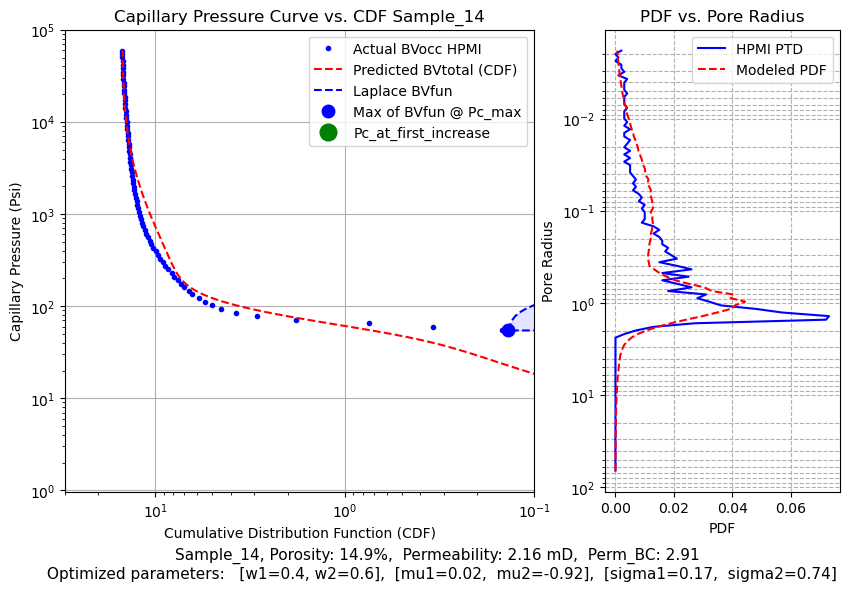

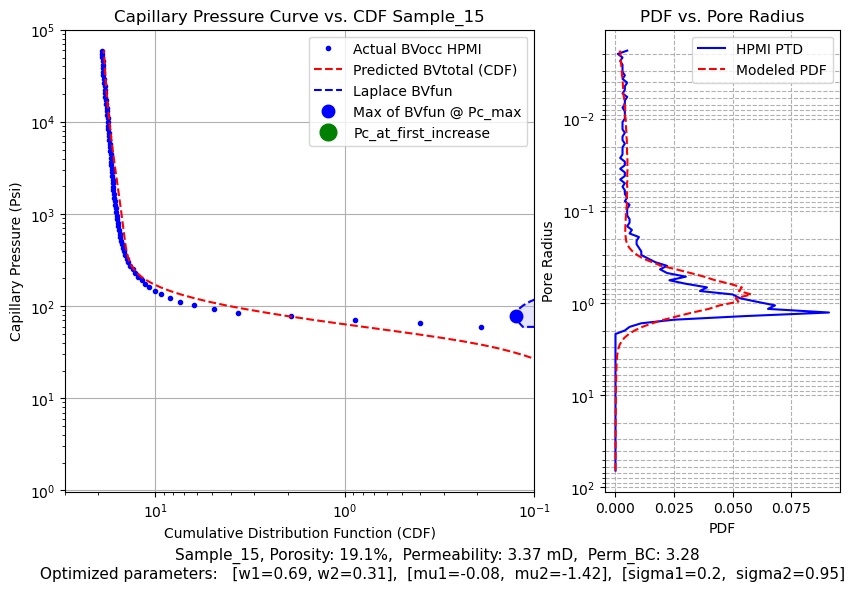

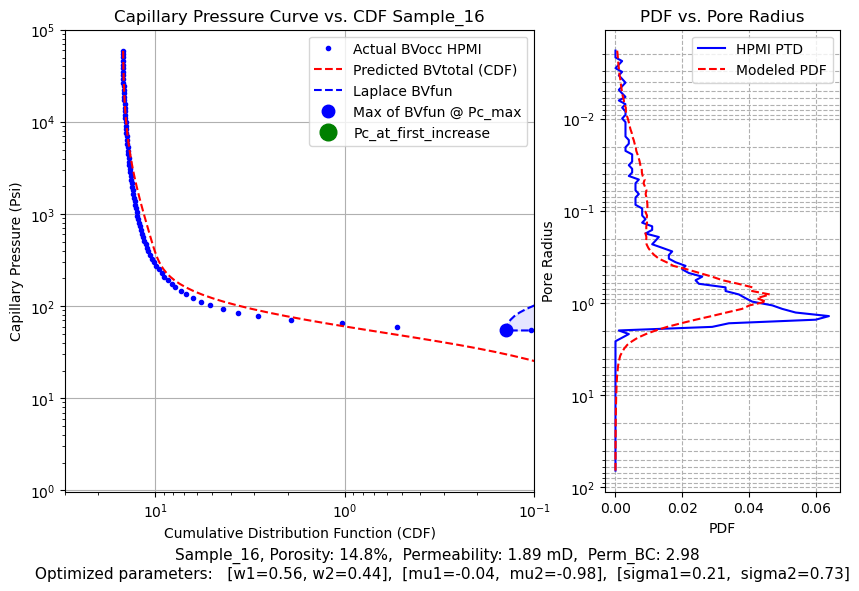

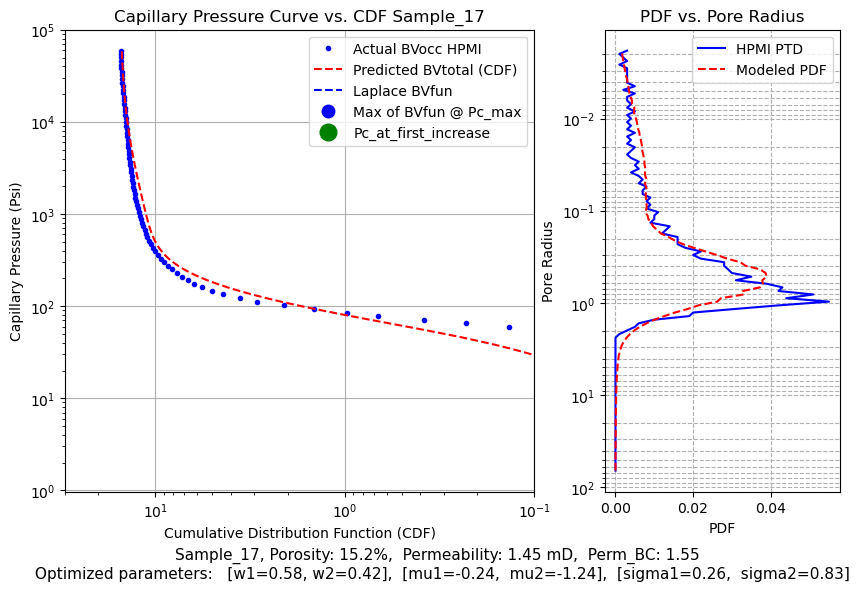

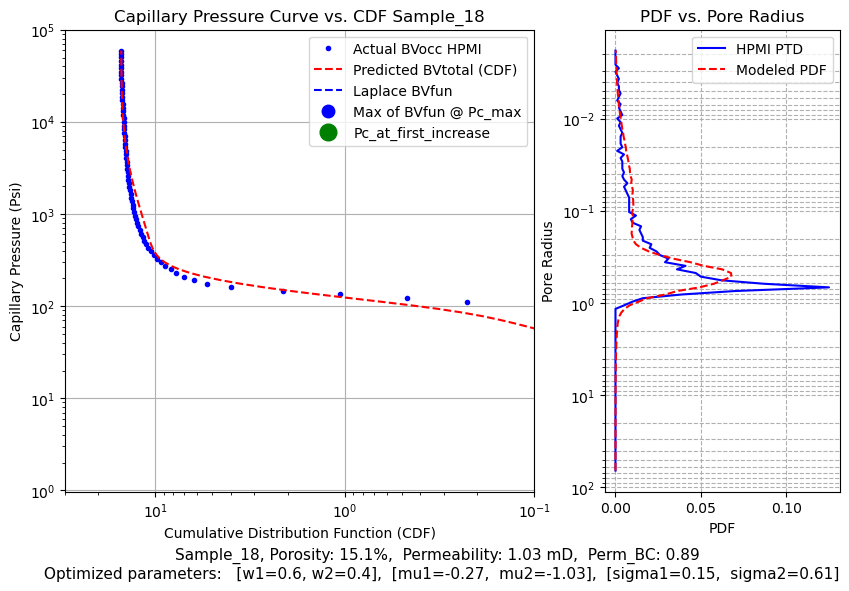

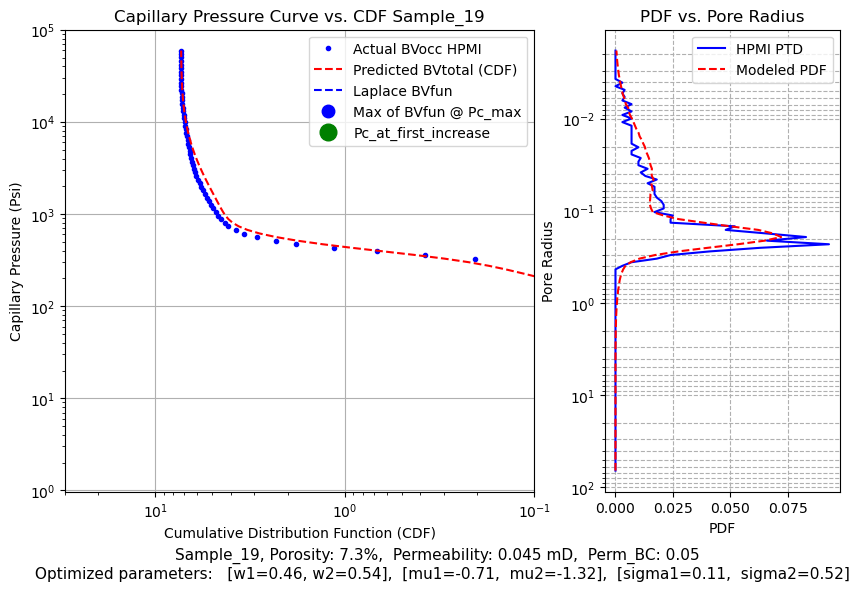

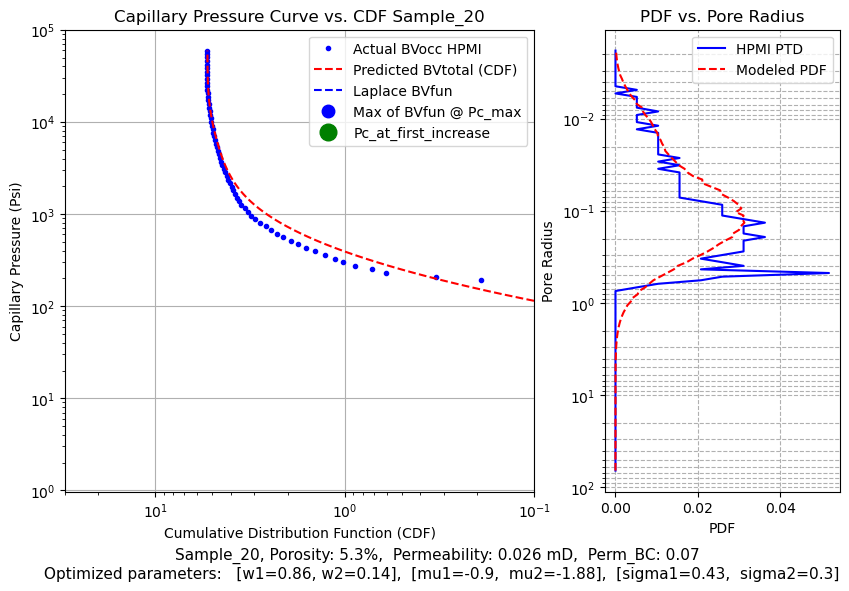

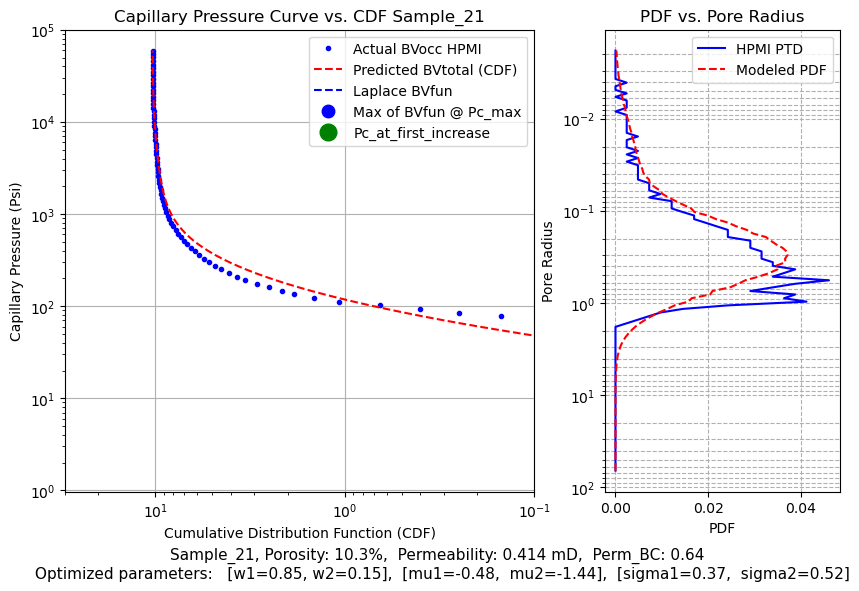

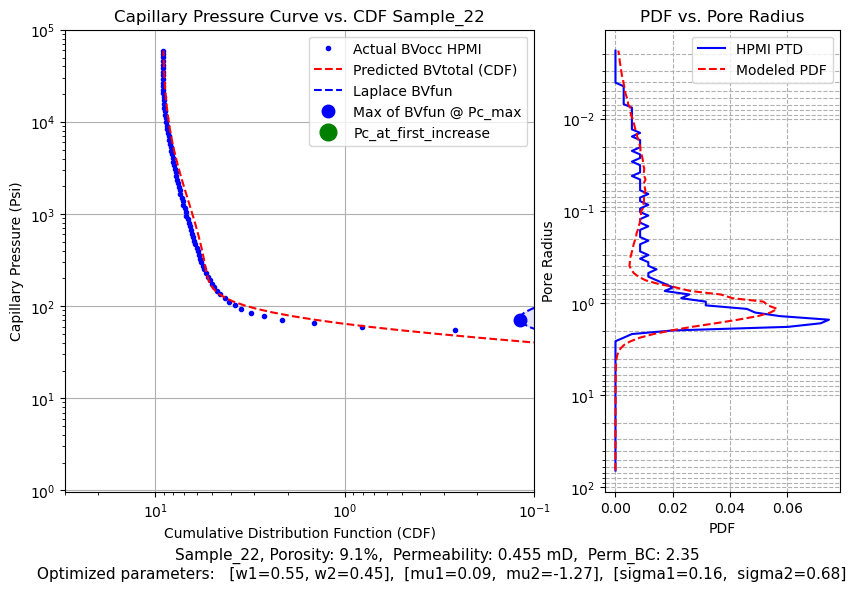

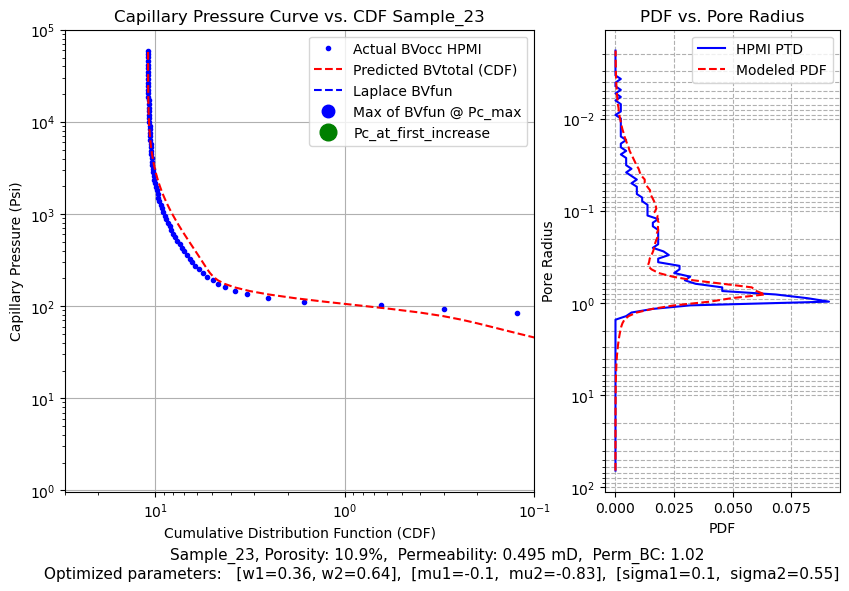

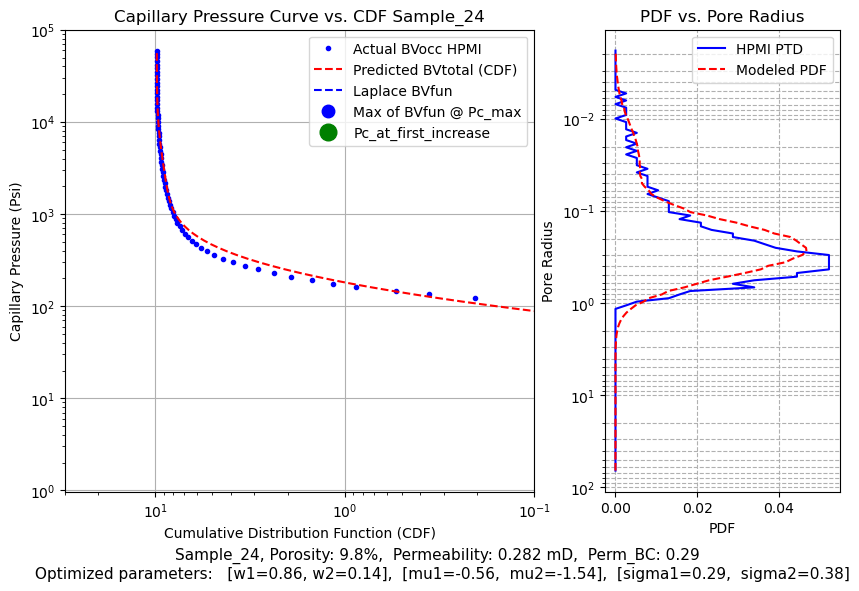

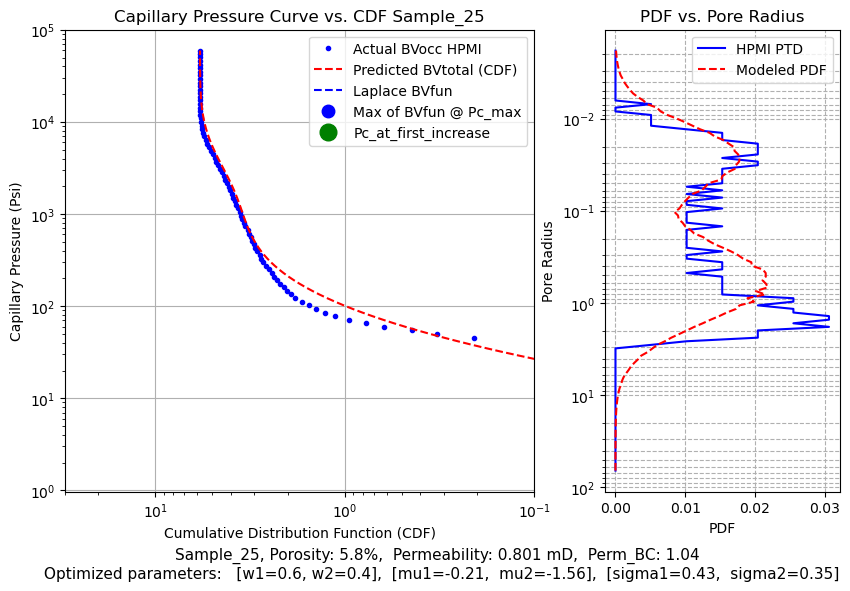

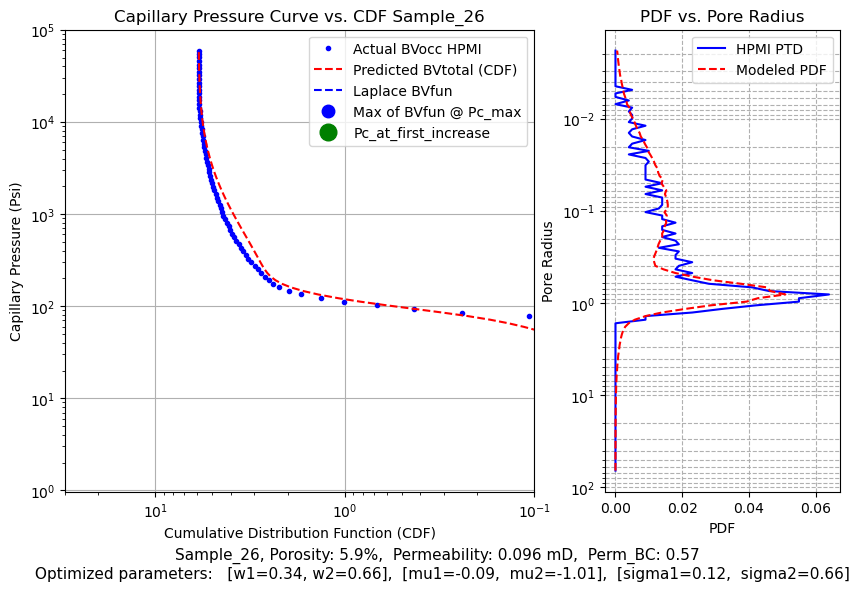

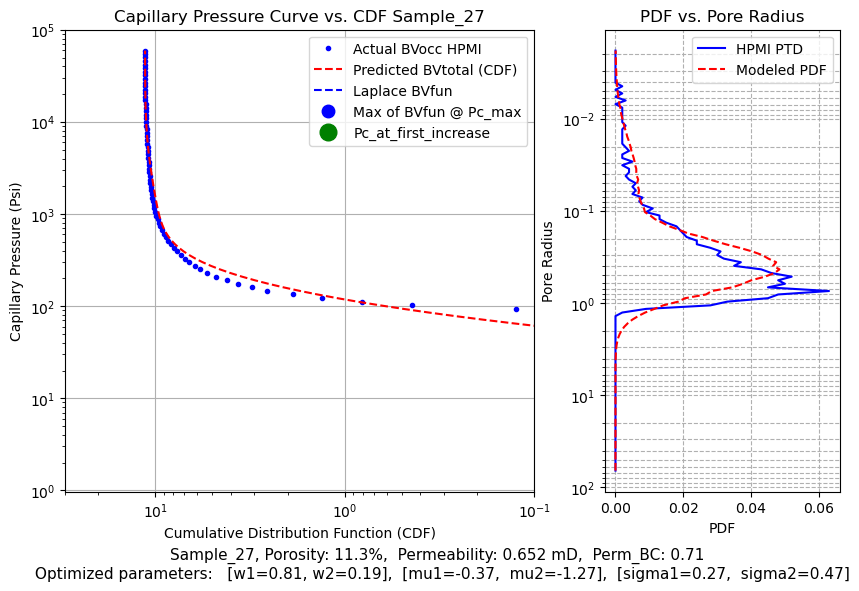

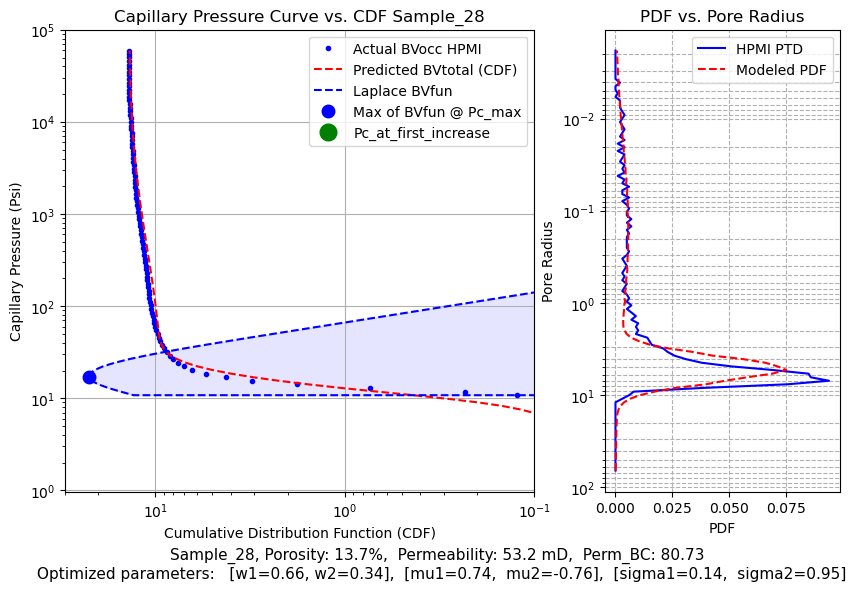

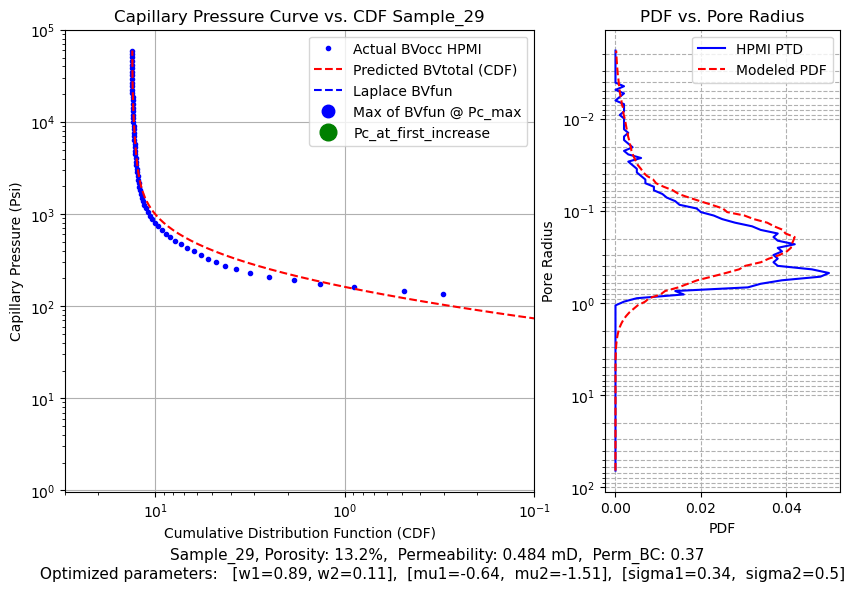

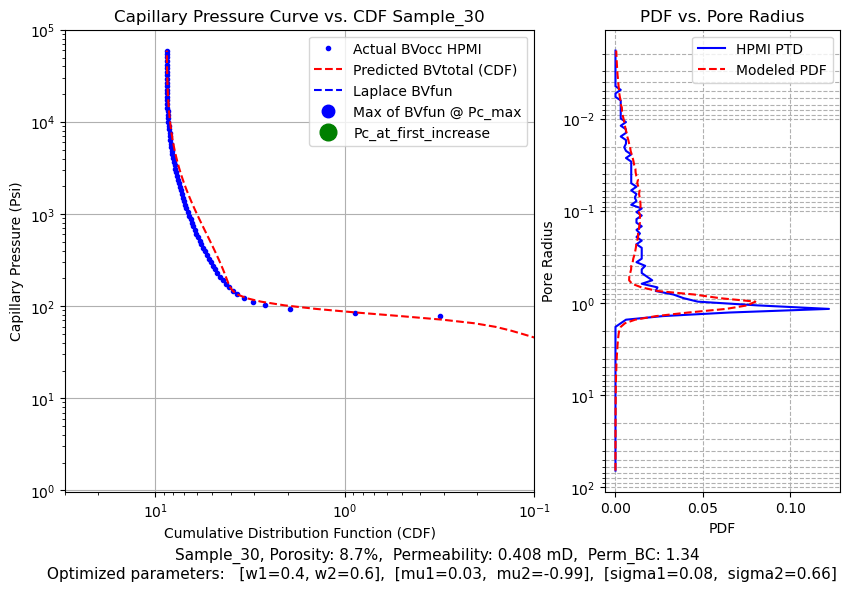

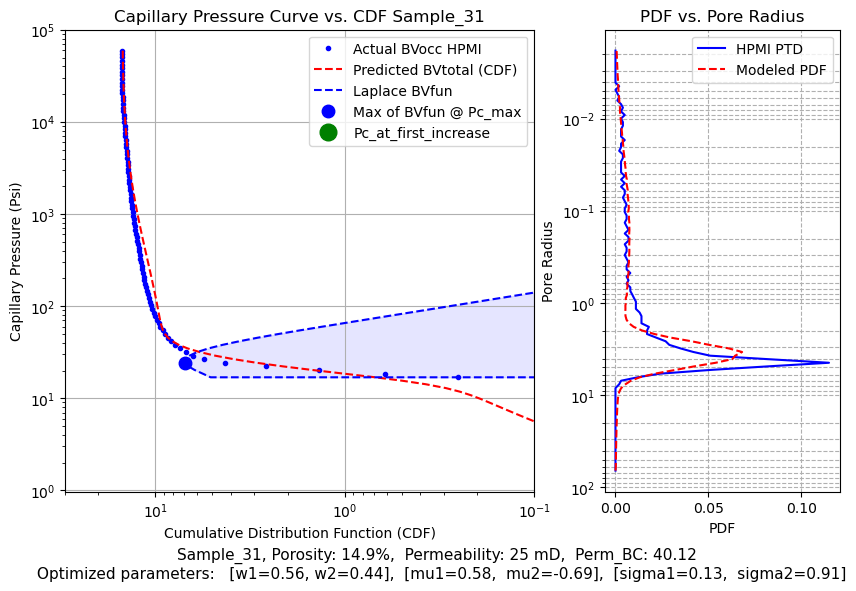

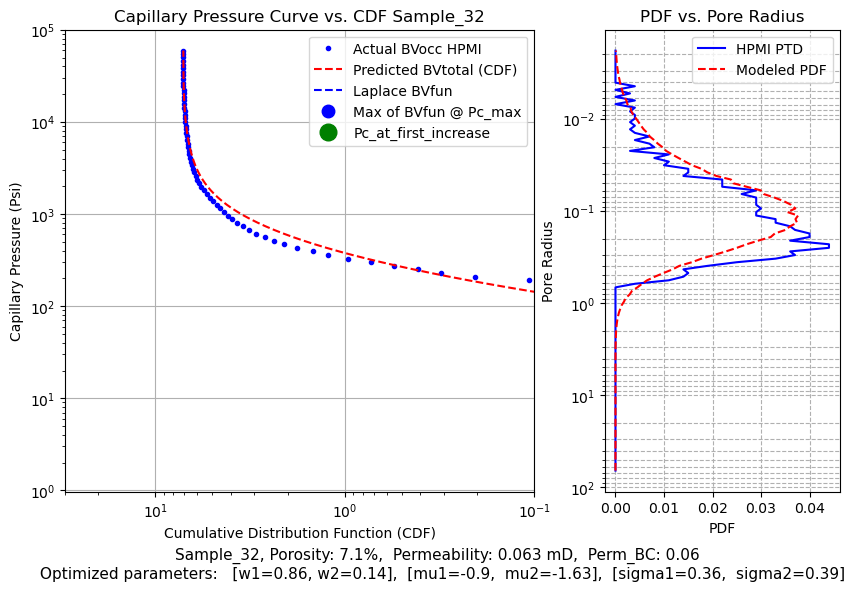

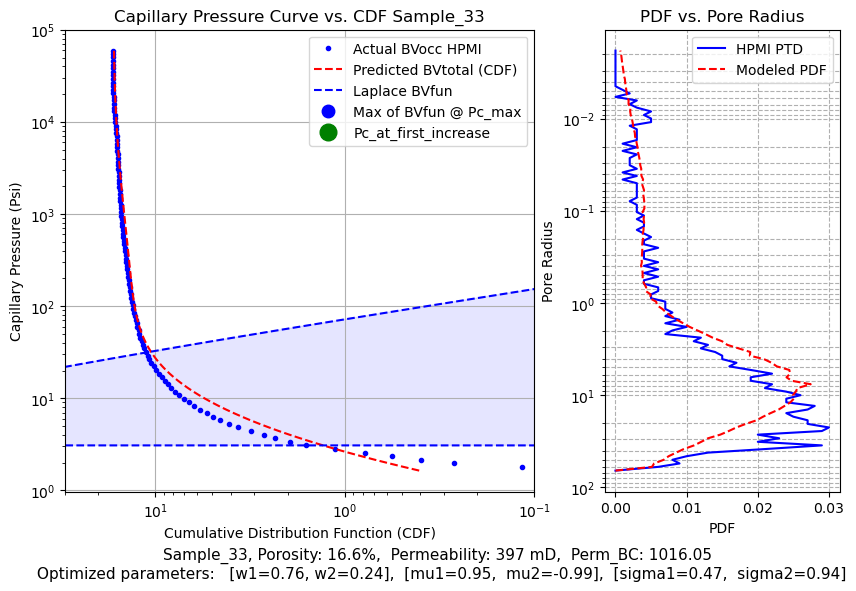

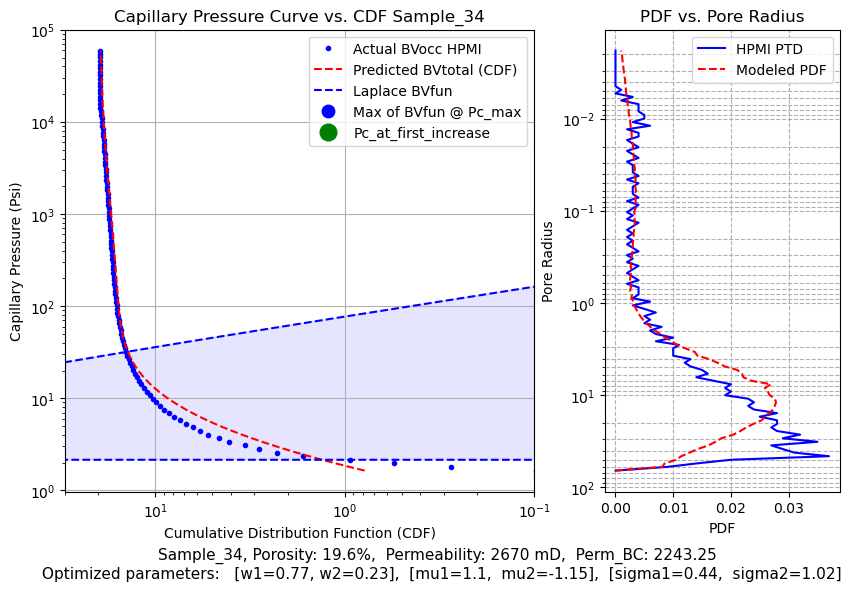

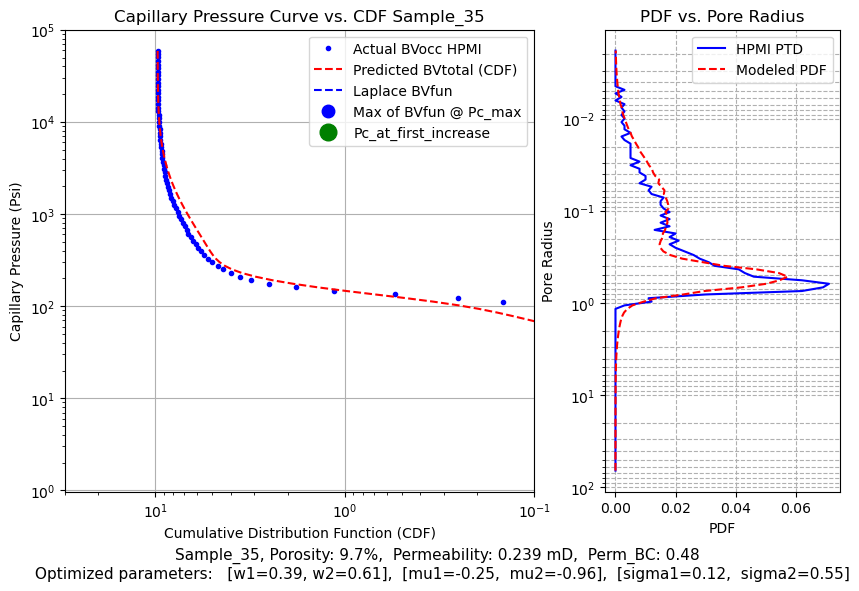

In [5]:
# Loop through all samples
for Sample in data_dict.keys():
    sample_data = data_dict[Sample]

    porosity_sample = sample_data['Porosity (%)']
    perm_sample = sample_data['Permeability']
    Num_pore_sys = sample_data['Num_pore_sys']


    Pc = sample_data['Pc']
    Sw = sample_data['Sw']/100

    
    BVocc = (1 - Sw) * porosity_sample
    #print(BVocc)
 
    #dbvocc = np.diff(BVocc)  # diff of BVocc for distribution, but lose one element in the array
    #dbvocc = np.insert(dbvocc, 0, 0)  # Our final dbvocc after adding a zero at the start
   

    dSw = np.diff(-1*Sw)
    dSw = np.insert(dSw,0,0)
    #print('dSw', len(dSw) )  # 118 element array

    

    
    def micp_to_gev(Pc, Sw, IFTheta, n):
        
        Rc = 2 * IFTheta * 0.147 / Pc
    
        ''' Initial guess (using w1, w2, mu1, mu2, sig1, sig2) '''
        x0 =          np.array([0.8, 0.2, -0.5, -2, 0.6, 0.05])
    
        ''' Lower and upper bounds (matching new order) '''
        lb = np.array([0.002, 0.002, np.log10(Rc[-1]), np.log10(Rc[-1]), 0.01, 0.01])
        ub = np.array([1, 1, np.log10(Rc[0]), np.log10(Rc[0]), 5, 5])
    
        ''' Constraints (apply to weights only) '''
        Aeq = np.array([1, 1] + [0] * 4)  # Constrain only w1 and w2 to sum to 1
        Beq = np.array([1])
    
        ''' Objective function '''
        def gev_cost_function(t):
            return gev_cost(np.log10(Rc), Sw, t, n)
    
        ''' Minimize the objective function with constraints '''
        cons = [{'type': 'eq', 'fun': lambda t: np.dot(Aeq, t) - Beq}]
        bounds = [(low, high) for low, high in zip(lb, ub)]
    
        res = minimize(gev_cost_function, x0, bounds=bounds, constraints=cons, method='SLSQP')
    
        ''' Extract parameters directly in the expected order '''
        x = res.x
        w1, w2 = x[0], x[1]
        mu1, mu2 = x[2], x[3]
        sig1, sig2 = x[4], x[5]


        ''' 
        This does not work well, but we could have w1 > w2, but not recommended as coded below:
        ---------------------------------------------------------------------------------------
        Ensure that w1, mu1, and sig1 represent the most dominant pore system (largest weight) '''
        '''if w2 > w1:
            # Swap w1 and w2, mu1 and mu2, sig1 and sig2
            w1, w2 = w2, w1
            mu1, mu2 = mu2, mu1
            sig1, sig2 = sig2, sig1'''

        
        ''' No need to sort! Everything is already in order '''
        Sw1 = np.zeros_like(Sw)
        pdf = np.zeros_like(Sw)
        for i in range(len(Pc)):
            Sw1[i] = np.sum(norm.cdf(np.log10(Rc[i]), [mu1, mu2], [sig1, sig2]) * [w1, w2])
            #pdf[i] = np.sum(norm.pdf(np.log10(Rc[i]), [mu1, mu2], [sig1, sig2]) * [w1, w2])

        BVocc_est = (porosity_sample/100) * (1 - Sw1)*100
        
        pdf = np.diff(-1*Sw1)
        pdf = np.insert(pdf,0,0)

        #print('pdf', len(pdf) ) # 118 element array


        #first_increase_index = np.argmax(pdf > 0.0 ) + 1  # +1 because diff reduces length by 1
        #first_increase_index = np.argmax(pdf > 0.001 ) + 1  # +1 because diff reduces length by 1
        #first_increase_index = np.argmax(pdf > 0.0005 )       # +1 because diff reduces length by 1
        first_increase_index = np.argmax(pdf > 0.01 )     # +1 because diff reduces length by 1

        # Get the corresponding Pc value at this index
        Pc_at_first_increase = Pc[first_increase_index]
        
        
        return w1, w2, mu1, mu2, sig1, sig2, x, Sw1, pdf, Rc, BVocc_est, Pc_at_first_increase
    


    def gev_cost(X, c, t, n):
        w = t[:n]
        mu = t[n:2 * n]
        sigma = t[2 * n:]
    
        cm = np.zeros_like(c)
        for i in range(len(X)):
            cm[i] = np.sum(genextreme.cdf(X[i], 0.5 , mu, sigma) * w)  # xi=0 for Gumbel (special case of GEV)
    
        c = np.array(c)  # Ensure c is a numpy array
        
        # Element-wise comparison
        idx = np.where(c <= 1)[0]
        e   = np.linalg.norm(cm[idx] - c[idx])
    
        return e
    
    
    
    def plot_micp_results_gev(Pc, Sw, Sw1):
    
        # Create the plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [2, 1]})

        
        ax1.plot(BVocc, Pc, 'bo', markersize=3, label='Actual BVocc HPMI')
        ax1.plot(BVocc_est, Pc, 'r--', label='Predicted BVtotal (CDF)')
        ax1.plot(50000*BVfun, Pc, 'b--', label='Laplace BVfun')
        #plt.scatter(BVfun_max, Pc_max, color='red', label=f"Max BVfun: {BVfun_max:.2f} at Pc: {Pc_max:.2f}")
        #plt.plot(BVfun_max, Pc_max, color='red', label=f"Max BVfun: {BVfun_max:.2f} at Pc: {Pc_max:.2f}")
        ax1.plot(50000*BVfun_max, Pc_max, 'bo', label='Max of BVfun @ Pc_max', markersize=9)
        #ax1.plot(np.exp(-2*Dlambda*np.log(Pc)), Pc, 'r-', label='Laplace BVfun')
        ax1.plot(0.01, Pc_at_first_increase, 'go', label='Pc_at_first_increase', markersize=12)
        # Fill from 50000 * BVfun to 0.01 on the x-axis
        ax1.fill_betweenx(Pc,50000 * BVfun, 0.01, where=(50000 * BVfun >= 0.01), color='blue', alpha=0.1)
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.set_xlim(30, 0.1)
        #ax.set_xscale('linear')
        ax1.set_xlabel('Cumulative Distribution Function (CDF)')
        ax1.set_ylabel('Capillary Pressure (Psi)')
        ax1.set_title(f'Capillary Pressure Curve vs. CDF {Sample}')
        ax1.grid(True)
        ax1.legend()

   
        # Add the text below the plot
        text_string = (f'{Sample}, Porosity: {porosity_sample}%, '
                       f' Permeability: {perm_sample} mD,  Perm_BC: {round(Perm_BC,2)} \n '
                       f'Optimized parameters:   [w1={round(w1, 2)}, w2={round(1-w1, 2)}],  '
                       f'[mu1={round(mu1, 2)},  mu2={round(mu2, 2)}],  '
                       f'[sigma1={round(sig1, 2)},  sigma2={round(sig2, 2)}]')
    
        # Adjust the position of the text as needed
        plt.figtext(0.5, -0.03, text_string, ha="center", fontsize=11, wrap=True)
    
        
        # Plot PDF with reversed axes
        #ax2.plot(dPDF, Rc, 'g-', label='dPDF')       
        ax2.plot(dSw, Rc, 'b-', label='HPMI PTD')
        ax2.plot(pdf, Rc, 'r--', label='Modeled PDF')
        #ax2.plot(5*dbvocc, Rc, 'g--', label='dbvocc')
        
        #ax2.plot(Swanson_raw, Rc, 'r-', linewidth = 3, label='Swanson')        
        #ax2.plot(np.max(pdf), 10**mu1, 'ro', label='Mode of PTD')
        ax2.set_xscale('linear')
        ax2.set_yscale('log')
        plt.gca().invert_yaxis()
        ax2.set_xlabel('PDF')
        ax2.set_ylabel('Pore Radius')
        ax2.set_title('PDF vs. Pore Radius')
        ax2.grid(True, which="both", ls="--")
        ax2.legend()



    ''' Data Entry '''    
    # Example usage (replace Pc, Sw, IFTheta with real values):
    Pc = np.array(Pc)  # Replace with actual Pc values
    Sw = np.array(Sw)  # Replace with actual Sw values
   
    
    # IFTheta needs to be positive
    IFTheta = abs(480 * np.cos(np.radians(140)))  # Use the absolute value of IFTheta
    n = 2  # Number of Gaussian components
    
    
    # Run the model and plot results
    result = micp_to_gev(Pc, Sw, IFTheta, n)
    
    
    w1, w2, mu1, mu2, sig1, sig2, x, Sw1, pdf, Rc, BVocc_est , Pc_at_first_increase = result

    ######print( 'Pc_at_first_increase:', Pc_at_first_increase)

    #Mode = mu1 

    dbvocc = np.diff(BVocc_est)  # diff of BVocc for distribution, but lose one element in the array
    dbvocc = np.insert(dbvocc, 0, 0)  # Our final dbvocc after adding a zero at the start


    Pd1_calc =  10**((np.log10(perm_sample) - 3.33)/-1.71)

    
    '''Buiting-Clerke's Perms'''
    Dlambda = 1.56
    LLd      = 0.5

    # Calculate BVfun for each element in Pc
    BVfun     = np.where(Pc >= Pc_at_first_increase, BVocc_est * np.exp(-(2 * Dlambda) * np.log(Pc))   , 0.00)
    BVfun_sum = np.sum(BVfun)
    
    Constant  = ((np.exp((-2* (1 - Dlambda))*np.log(Pc_at_first_increase)))*(Dlambda/4))*LLd**2

    Ksi       = 107               # ξ =   2[sigma * cos(θ)]Hg–Air ≈ 734 dyn/cm = 107 psi μm)
    Perm_BC   = BVfun_sum * Constant * Ksi**2

    # Find the maximum point in BVfun
    max_index = np.argmax(BVfun)  # Index of maximum value in BVfun
    Pc_max = Pc[max_index]        # Pc value at maximum BVfun
    BVfun_max = BVfun[max_index]  # Maximum BVfun value



    
    
    
    #Perm_Mode_xi = 10**(1.9283 * Mode_xi + 0.03)
    # From our Perm model shown below with r2 of 0.927
    #Perm_Mode_xi = 10**( -1.1164 + (3.0140 * Mode_xi)  + (0.0748 * porosity_sample)    + (-1.4857 * mu1))
    #Perm_Mode  = 10**( -0.1487 + (-4.6533 * Mode) + (2.0291 * np.log10(Perm_BC))  + (2.1116 * mu1))
    
    plot_micp_results_gev(Pc, Sw, Sw1)
    

    # Optionally save the optimization results to an Excel file
    output_excel_file = 'Sample_Optimization_Results_Optimization_GEV_CDF_PDF.xlsx'

    '''if minimized_error > error_threshold:
        print("Bad result, optimization error is too high.")
    else:
        #print("Good result, acceptable optimization error.")'''

        
    data_to_save = {
        'Sample': Sample,
        'Porosity': porosity_sample,
        'Permeability': perm_sample,
         #'Perm_Mode': Perm_Mode,       
        'Perm_BC': Perm_BC,       
        'BVfun_sum': BVfun_sum,       
        'Pc_at_first_increase': Pc_at_first_increase,       
        'Pc_max': Pc_max,       
        'BVfun_max': BVfun_max,       
        'w1': round(w1, 3),
        'mu1': round(mu1, 2),
        'mu2': round(mu2, 2),
        'sigma1': round(sig1, 2),
        'sigma2': round(sig2, 2),
         #'Mode': round(Mode,2) ,        
        'Num_pore_sys': Num_pore_sys,
        
    }

   
    df = pd.DataFrame([data_to_save])

    # Check if the file already exists
    if os.path.exists(output_excel_file):
        with pd.ExcelWriter(output_excel_file, mode='a', if_sheet_exists='overlay', engine='openpyxl') as writer:
            df.to_excel(writer, index=False, header=False, startrow=writer.sheets['Sheet1'].max_row)
    else:
        df.to_excel(output_excel_file, index=False)



# Load Results from each sample run in the Automatic GEV Mode:

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 

# Specify the file path and sheet number
file_path = 'Sample_Optimization_Results_Optimization_GEV_CDF_PDF.xlsx'

# Read the specific range from the sheet
df = pd.read_excel(file_path)

df.head()

Sample  Porosity  Permeability     Perm_BC  BVfun_sum  \
0  Sample_1      19.5         23.40   14.259061   0.000265   
1  Sample_2      14.5         41.40  324.234599   0.049897   
2  Sample_3      14.5         41.40  161.788444   0.016660   
3  Sample_4      13.9          6.88   78.531366   0.005403   
4  Sample_5      13.9          6.88   43.074894   0.002201   

   Pc_at_first_increase  Pc_max  BVfun_max     w1   mu1   mu2  sigma1  sigma2  \
0                 31.80   54.50   0.000023  0.749  0.26 -1.13    0.14    0.98   
1                  4.82    4.82   0.005212  0.627  0.93 -0.88    0.27    1.16   
2                  6.90    6.90   0.001579  0.710  0.78 -1.10    0.27    0.87   
3                  9.89    9.89   0.000639  0.617  0.62 -1.32    0.31    0.96   
4                 12.90   12.90   0.000293  0.709  0.39 -1.17    0.39    0.59   

   Num_pore_sys  
0             1  
1             2  
2             2  
3             2  
4             2

In [7]:
# Assuming porosity and permeability data are stored in numpy arrays
porosity = df['Porosity']
permeability = df['Permeability']  # Replace with actual permeability data
df['lperm'] = np.log10(df['Permeability'])  # Replace with actual permeability data
lperm = df['lperm']
w1 = df['w1']  # Replace with actual permeability data
mu1 = df['mu1']  # Replace with actual permeability data
#df['lmu1'] = np.log10(df['mu1'])  # Replace with actual permeability data
#lmu1 = df['lmu1']
sigma1 = df['sigma1']  # Replace with actual permeability data
#Mode = df['Mode']
#Perm_Mode = df['Perm_Mode']
Perm_BC = df['Perm_BC']
BVfun_sum = df['BVfun_sum']
Pc_at_first_increase = df['Pc_at_first_increase']
Pc_max = df['Pc_max']
BVfun_max = df['BVfun_max']



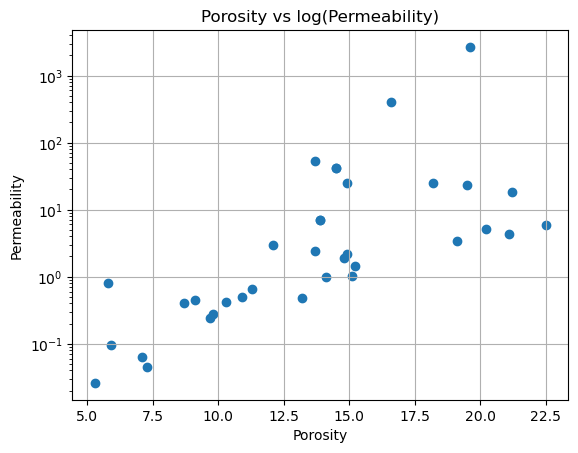

In [8]:
plt.scatter(porosity, permeability)
plt.xlabel('Porosity')
plt.ylabel('Permeability')
plt.title('Porosity vs log(Permeability)')
plt.yscale('log')
plt.grid()

plt.show()


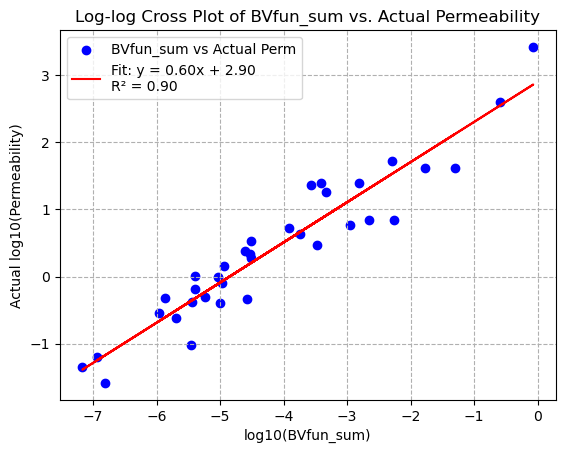

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Log-transform the data for linear regression
log_perm_pred = np.log10(BVfun_sum)
log_perm = np.log10(permeability)

# Perform linear regression on the log-transformed data
slope, intercept = np.polyfit(log_perm_pred, log_perm, 1)

# Calculate the regression line values based on the log-perm predictions
log_perm_fit = slope * log_perm_pred + intercept

# Calculate R² for the log-log regression
ss_res = np.sum((log_perm - log_perm_fit) ** 2)  # Residual sum of squares
ss_tot = np.sum((log_perm - np.mean(log_perm)) ** 2)  # Total sum of squares
r2 = 1 - (ss_res / ss_tot)

# Plot the scatter plot in log-log scale (log_perm_pred vs. log_perm)
plt.scatter(log_perm_pred, log_perm, label='BVfun_sum vs Actual Perm', color='blue')

# Plot the regression line
plt.plot(log_perm_pred, log_perm_fit, color='red', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}\nR² = {r2:.2f}')

# Add labels, title, and grid
plt.xlabel('log10(BVfun_sum)')
plt.ylabel('Actual log10(Permeability)')
plt.title('Log-log Cross Plot of BVfun_sum vs. Actual Permeability')
plt.grid(True, which='both', ls='--')

# Add legend for the regression equation and R²
plt.legend()

# Show the plot
plt.show()


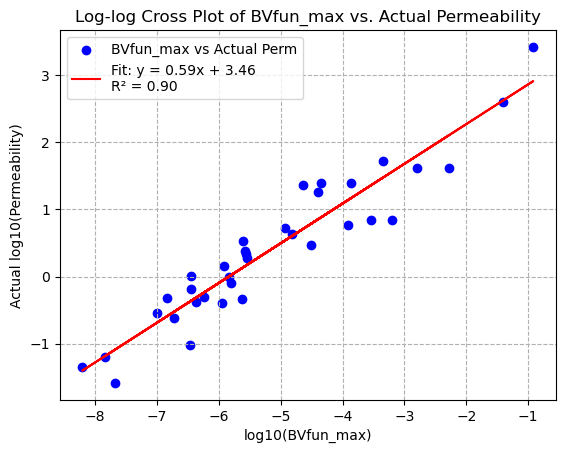

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Log-transform the data for linear regression
log_perm_pred = np.log10(BVfun_max)
log_perm = np.log10(permeability)

# Perform linear regression on the log-transformed data
slope, intercept = np.polyfit(log_perm_pred, log_perm, 1)

# Calculate the regression line values based on the log-perm predictions
log_perm_fit = slope * log_perm_pred + intercept

# Calculate R² for the log-log regression
ss_res = np.sum((log_perm - log_perm_fit) ** 2)  # Residual sum of squares
ss_tot = np.sum((log_perm - np.mean(log_perm)) ** 2)  # Total sum of squares
r2 = 1 - (ss_res / ss_tot)

# Plot the scatter plot in log-log scale (log_perm_pred vs. log_perm)
plt.scatter(log_perm_pred, log_perm, label='BVfun_max vs Actual Perm', color='blue')

# Plot the regression line
plt.plot(log_perm_pred, log_perm_fit, color='red', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}\nR² = {r2:.2f}')

# Add labels, title, and grid
plt.xlabel('log10(BVfun_max)')
plt.ylabel('Actual log10(Permeability)')
plt.title('Log-log Cross Plot of BVfun_max vs. Actual Permeability')
plt.grid(True, which='both', ls='--')

# Add legend for the regression equation and R²
plt.legend()

# Show the plot
plt.show()


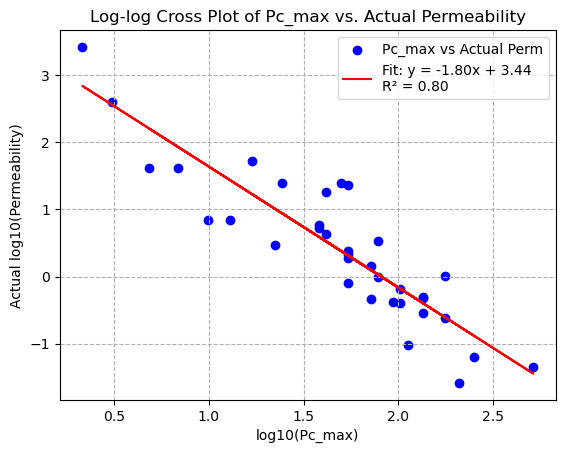

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Log-transform the data for linear regression
log_perm_pred = np.log10(Pc_max)
log_perm = np.log10(permeability)

# Perform linear regression on the log-transformed data
slope, intercept = np.polyfit(log_perm_pred, log_perm, 1)

# Calculate the regression line values based on the log-perm predictions
log_perm_fit = slope * log_perm_pred + intercept

# Calculate R² for the log-log regression
ss_res = np.sum((log_perm - log_perm_fit) ** 2)  # Residual sum of squares
ss_tot = np.sum((log_perm - np.mean(log_perm)) ** 2)  # Total sum of squares
r2 = 1 - (ss_res / ss_tot)

# Plot the scatter plot in log-log scale (log_perm_pred vs. log_perm)
plt.scatter(log_perm_pred, log_perm, label='Pc_max vs Actual Perm', color='blue')

# Plot the regression line
plt.plot(log_perm_pred, log_perm_fit, color='red', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}\nR² = {r2:.2f}')

# Add labels, title, and grid
plt.xlabel('log10(Pc_max)')
plt.ylabel('Actual log10(Permeability)')
plt.title('Log-log Cross Plot of Pc_max vs. Actual Permeability')
plt.grid(True, which='both', ls='--')

# Add legend for the regression equation and R²
plt.legend()

# Show the plot
plt.show()


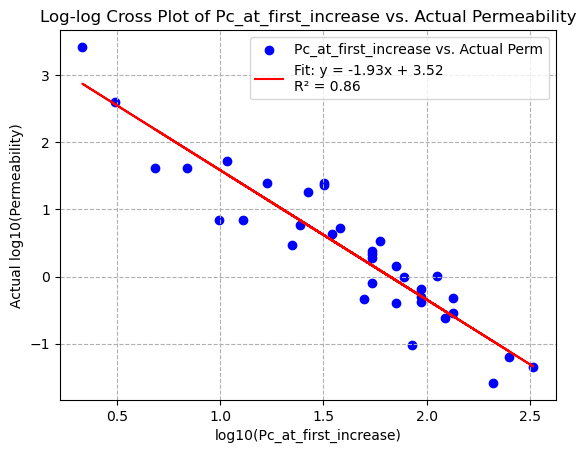

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Log-transform the data for linear regression
log_perm_pred = np.log10(Pc_at_first_increase	)
log_perm = np.log10(permeability)

# Perform linear regression on the log-transformed data
slope, intercept = np.polyfit(log_perm_pred, log_perm, 1)

# Calculate the regression line values based on the log-perm predictions
log_perm_fit = slope * log_perm_pred + intercept

# Calculate R² for the log-log regression
ss_res = np.sum((log_perm - log_perm_fit) ** 2)  # Residual sum of squares
ss_tot = np.sum((log_perm - np.mean(log_perm)) ** 2)  # Total sum of squares
r2 = 1 - (ss_res / ss_tot)

# Plot the scatter plot in log-log scale (log_perm_pred vs. log_perm)
plt.scatter(log_perm_pred, log_perm, label='Pc_at_first_increase vs. Actual Perm', color='blue')

# Plot the regression line
plt.plot(log_perm_pred, log_perm_fit, color='red', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}\nR² = {r2:.2f}')

# Add labels, title, and grid
plt.xlabel('log10(Pc_at_first_increase)')
plt.ylabel('Actual log10(Permeability)')
plt.title('Log-log Cross Plot of Pc_at_first_increase vs. Actual Permeability')
plt.grid(True, which='both', ls='--')

# Add legend for the regression equation and R²
plt.legend()

# Show the plot
plt.show()


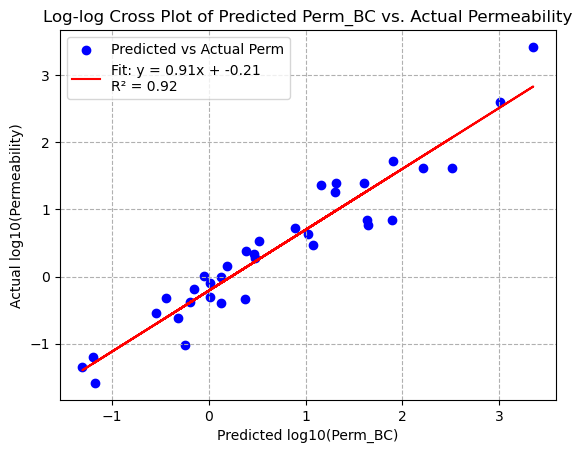

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Log-transform the data for linear regression
log_perm_pred = np.log10(Perm_BC)
log_perm = np.log10(permeability)

# Perform linear regression on the log-transformed data
slope, intercept = np.polyfit(log_perm_pred, log_perm, 1)

# Calculate the regression line values based on the log-perm predictions
log_perm_fit = slope * log_perm_pred + intercept

# Calculate R² for the log-log regression
ss_res = np.sum((log_perm - log_perm_fit) ** 2)  # Residual sum of squares
ss_tot = np.sum((log_perm - np.mean(log_perm)) ** 2)  # Total sum of squares
r2 = 1 - (ss_res / ss_tot)

# Plot the scatter plot in log-log scale (log_perm_pred vs. log_perm)
plt.scatter(log_perm_pred, log_perm, label='Predicted vs Actual Perm', color='blue')

# Plot the regression line
plt.plot(log_perm_pred, log_perm_fit, color='red', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}\nR² = {r2:.2f}')

# Add labels, title, and grid
plt.xlabel('Predicted log10(Perm_BC)')
plt.ylabel('Actual log10(Permeability)')
plt.title('Log-log Cross Plot of Predicted Perm_BC vs. Actual Permeability')
plt.grid(True, which='both', ls='--')

# Add legend for the regression equation and R²
plt.legend()

# Show the plot
plt.show()


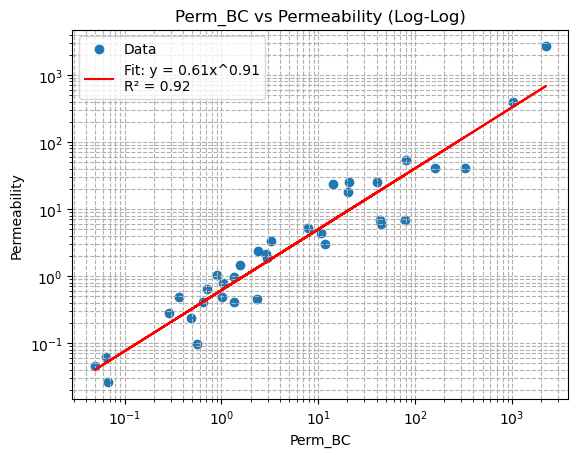

In [14]:
# Log-transform the data for linear regression
log_mu1 = np.log(Perm_BC)
log_perm = np.log(permeability)

# Perform linear regression on the log-transformed data
slope, intercept = np.polyfit(log_mu1, log_perm, 1)

# Calculate the predicted values in log scale
log_perm_pred = slope * log_mu1 + intercept

# Convert the predicted log-permeability back to the original scale
perm_pred = np.exp(log_perm_pred)

# Calculate R² for the log-log regression
ss_res = np.sum((log_perm - log_perm_pred) ** 2)  # Residual sum of squares in log scale
ss_tot = np.sum((log_perm - np.mean(log_perm)) ** 2)  # Total sum of squares in log scale
r2 = 1 - (ss_res / ss_tot)

# Plot the scatter plot in log-log scale
plt.scatter(Perm_BC, permeability, label='Data')

# Plot the regression line in the original scale
plt.plot(Perm_BC, perm_pred, color='red', label=f'Fit: y = {np.exp(intercept):.2f}x^{slope:.2f}\nR² = {r2:.2f}')

# Add labels, title, and grid
plt.xlabel('Perm_BC')
plt.ylabel('Permeability')
plt.title('Perm_BC vs Permeability (Log-Log)')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both', ls='--')

# Add legend for the regression equation and R²
plt.legend()

# Show the plot
plt.show()


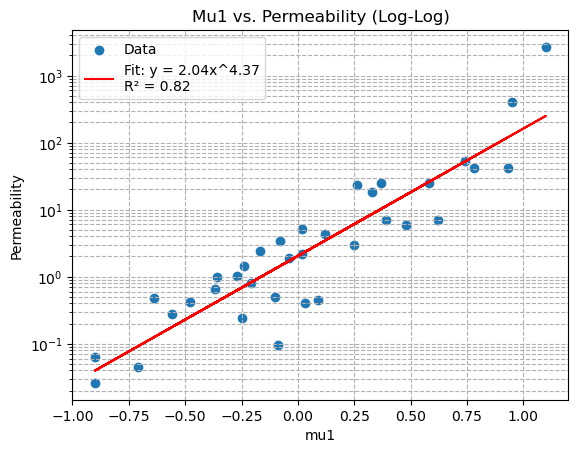

In [15]:
# Log-transform the data for linear regression
log_mu1 = mu1
log_perm = np.log(permeability)

# Perform linear regression on the log-transformed data
slope, intercept = np.polyfit(log_mu1, log_perm, 1)

# Calculate the predicted values in log scale
log_perm_pred = slope * log_mu1 + intercept

# Convert the predicted log-permeability back to the original scale
perm_pred = np.exp(log_perm_pred)

# Calculate R² for the log-log regression
ss_res = np.sum((log_perm - log_perm_pred) ** 2)  # Residual sum of squares in log scale
ss_tot = np.sum((log_perm - np.mean(log_perm)) ** 2)  # Total sum of squares in log scale
r2 = 1 - (ss_res / ss_tot)

# Plot the scatter plot in log-log scale
plt.scatter(mu1, permeability, label='Data')

# Plot the regression line in the original scale
plt.plot(mu1, perm_pred, color='red', label=f'Fit: y = {np.exp(intercept):.2f}x^{slope:.2f}\nR² = {r2:.2f}')

# Add labels, title, and grid
plt.xlabel('mu1')
plt.ylabel('Permeability')
plt.title('Mu1 vs. Permeability (Log-Log)')
plt.xscale('linear')
plt.yscale('log')
plt.grid(True, which='both', ls='--')

# Add legend for the regression equation and R²
plt.legend()

# Show the plot
plt.show()


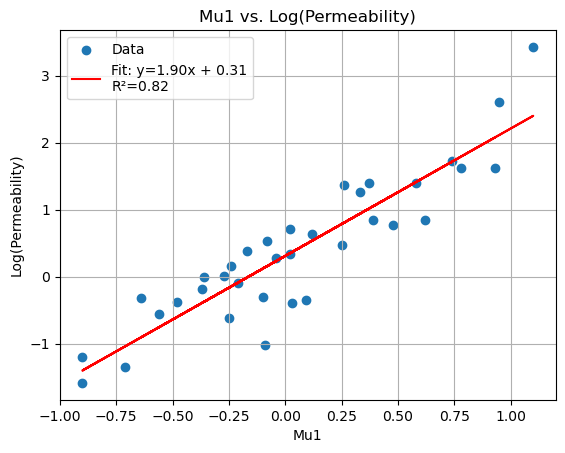

In [16]:
# Assuming lmu1 and lperm are the log-transformed data arrays for mu1 and permeability

# Perform linear regression using numpy.polyfit
slope, intercept = np.polyfit(mu1, lperm, 1)

# Calculate the predicted values for lperm
lperm_pred = slope * mu1 + intercept

# Calculate R² correctly
ss_res = np.sum((lperm - lperm_pred) ** 2)  # Residual sum of squares
ss_tot = np.sum((lperm - np.mean(lperm)) ** 2)  # Total sum of squares
r2 = 1 - (ss_res / ss_tot)

# Plot the scatter plot and the regression line
plt.scatter(mu1, lperm, label='Data')

# Plot the regression line (on the log-log scale)
plt.plot(mu1, lperm_pred, color='red', label=f'Fit: y={slope:.2f}x + {intercept:.2f}\nR²={r2:.2f}')

# Add labels, title, and grid
plt.xlabel('Mu1')
plt.ylabel('Log(Permeability)')
plt.title('Mu1 vs. Log(Permeability)')

plt.grid(True)

# Add legend
plt.legend()

# Show the plot
plt.show()


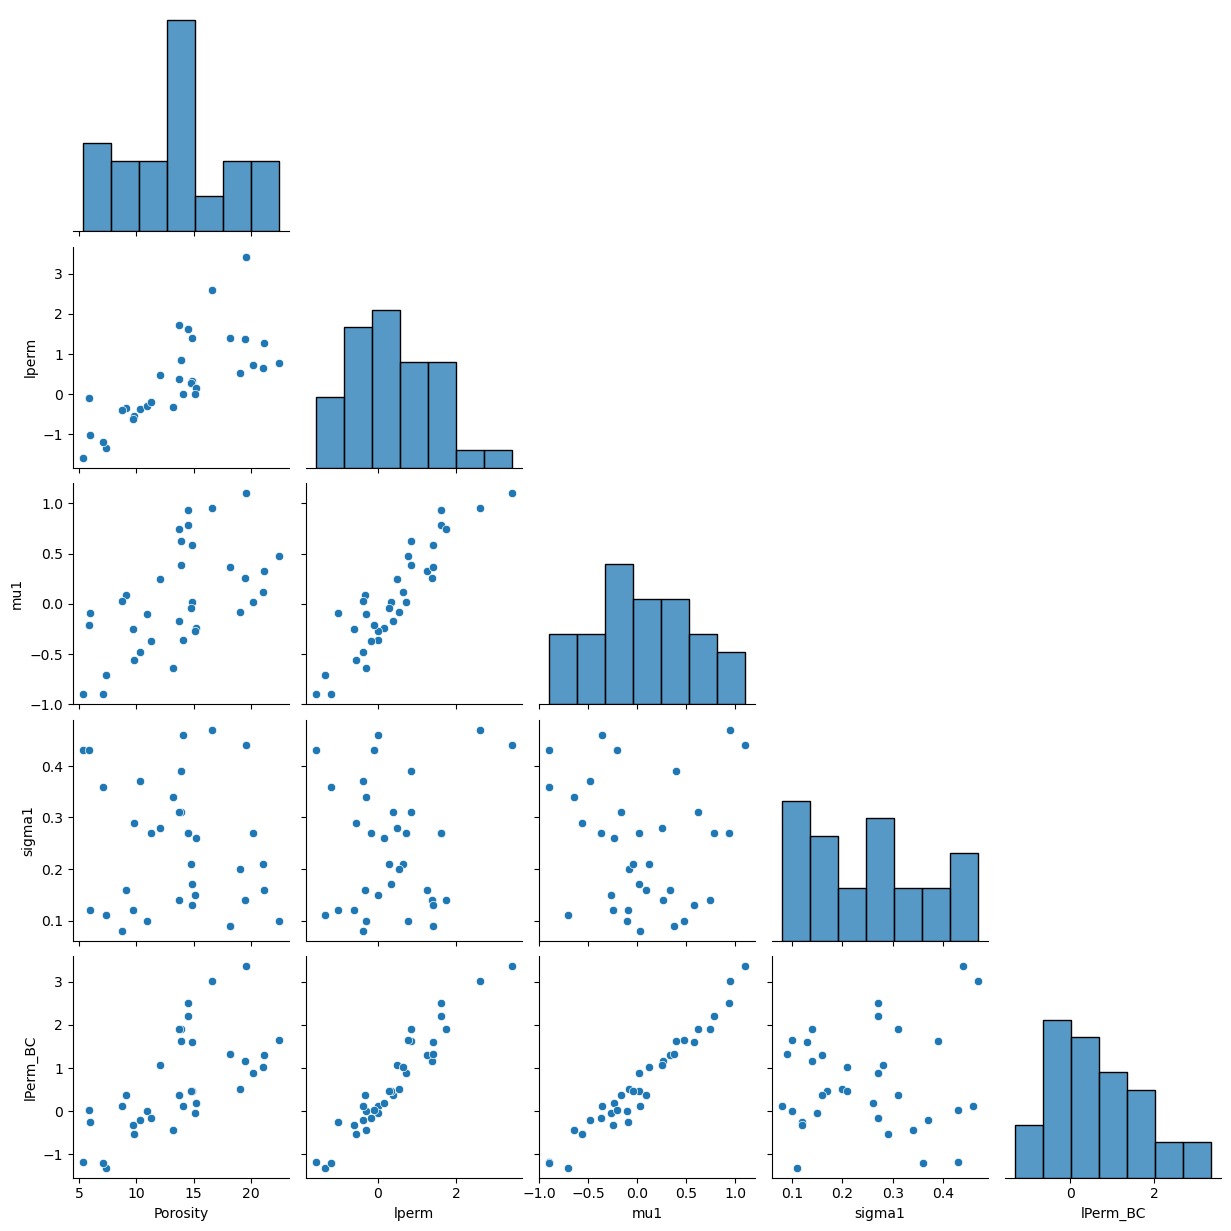

In [17]:
import seaborn as sns

df['lPerm_BC'] = np.log10(df['Perm_BC'])

# Create a new DataFrame with the columns of interest
data_to_plot = df[['Porosity', 'lperm',  'mu1', 'sigma1', 'lPerm_BC']]

# Create a pairplot of all the selected data
sns.pairplot(data_to_plot, corner=True)

# Show the plot


# Initial Perm Model: 

In [18]:
df.head()

Sample  Porosity  Permeability     Perm_BC  BVfun_sum  \
0  Sample_1      19.5         23.40   14.259061   0.000265   
1  Sample_2      14.5         41.40  324.234599   0.049897   
2  Sample_3      14.5         41.40  161.788444   0.016660   
3  Sample_4      13.9          6.88   78.531366   0.005403   
4  Sample_5      13.9          6.88   43.074894   0.002201   

   Pc_at_first_increase  Pc_max  BVfun_max     w1   mu1   mu2  sigma1  sigma2  \
0                 31.80   54.50   0.000023  0.749  0.26 -1.13    0.14    0.98   
1                  4.82    4.82   0.005212  0.627  0.93 -0.88    0.27    1.16   
2                  6.90    6.90   0.001579  0.710  0.78 -1.10    0.27    0.87   
3                  9.89    9.89   0.000639  0.617  0.62 -1.32    0.31    0.96   
4                 12.90   12.90   0.000293  0.709  0.39 -1.17    0.39    0.59   

   Num_pore_sys     lperm  lPerm_BC  
0             1  1.369216  1.154091  
1             2  1.617000  2.510859  
2             2  1.617000  2.208947  
3             2  0.837588  1.895043  
4             2  0.837588  1.634224

In [19]:
import pandas as pd
import numpy as np

df = df.drop(columns=['Sample'])

# Calculate log10(Permeability)
df['logPerm']  = np.log10(df['Permeability'])
df['lBVfun_sum'] = np.log10(df['BVfun_sum'])
df['lPc_max'] = np.log10(df['Pc_max'])
df['lBVfun_max'] = np.log10(df['BVfun_max'])

# Calculate the Pearson correlation matrix
correlation_matrix = df.corr()

# Display the correlations with logPerm
correlation_with_perm = correlation_matrix['logPerm']
print(correlation_with_perm)


Porosity                0.720902
Permeability            0.549132
Perm_BC                 0.649524
BVfun_sum               0.586670
Pc_at_first_increase   -0.780964
Pc_max                 -0.707216
BVfun_max               0.585313
w1                      0.194678
mu1                     0.906345
mu2                     0.378124
sigma1                  0.116948
sigma2                  0.763128
Num_pore_sys           -0.116069
lperm                   1.000000
lPerm_BC                0.957030
logPerm                 1.000000
lBVfun_sum              0.950067
lPc_max                -0.897178
lBVfun_max              0.946990
Name: logPerm, dtype: float64


In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Select top features (replace with actual top features from correlation analysis)
#X = df[['Mode_xi', 'Porosity', 'mu1']]  # Example of top 3 features
X = df[['lBVfun_sum', 'lPerm_BC', 'lBVfun_max', 'mu1']]  # Example of top 3 features
y = df['logPerm']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform multiple linear regression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predict on test set
y_pred = regressor.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R-squared: {r2}')
print(f'Mean Squared Error: {mse}')
print()

# Get the intercept and coefficients
intercept = regressor.intercept_
coefficients = regressor.coef_

print(intercept, coefficients)

# Print the equation
print("Linear Regression Equation: ")
print(f"y = {intercept:.4f} + ", end="")
for i, col in enumerate(X.columns):
    print(f"({coefficients[i]:.4f} * {col})", end=" + " if i < len(coefficients) - 1 else "\n")


R-squared: 0.8482794393453343
Mean Squared Error: 0.053071646391024595

-6.254856126940268 [ 0.15050923  2.88209774 -1.04674795 -1.39792033]
Linear Regression Equation: 
y = -6.2549 + (0.1505 * lBVfun_sum) + (2.8821 * lPerm_BC) + (-1.0467 * lBVfun_max) + (-1.3979 * mu1)


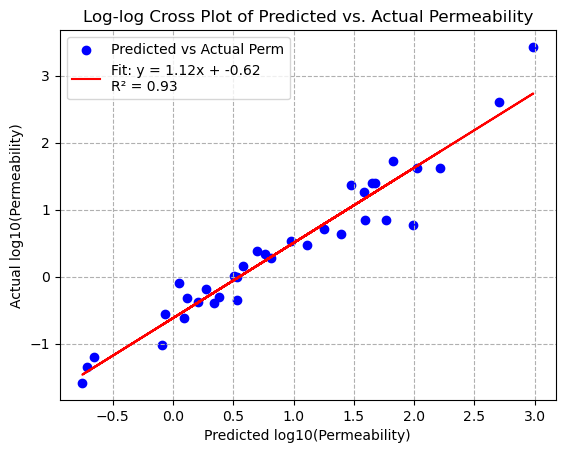

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Log-transform the data for linear regression
#log_perm_pred = -1.1164 + (3.0140 * Mode_xi) + (0.0748 * porosity) + (-1.4857 * mu1)

#log_perm_pred  = -8.1616 + (-1.2807 * df['lBVfun_sum']) + (3.1739 * df['lPerm_BC']) + (-0.2545 * df['lBVfun_max'])
#log_perm_pred  = -6.5377 + (-0.9745 * df['lBVfun_sum']) + (2.7283 * df['lPerm_BC']) + (-0.2958 * df['lBVfun_max'])
log_perm_pred = -6.7908 + (-0.9317 * df['lBVfun_sum']) + (2.9592 * df['lPerm_BC']) + (-0.3552 * df['lBVfun_max']) + (-0.4784 * df['mu1'])


log_perm = np.log10(permeability)

# Perform linear regression on the log-transformed data
slope, intercept = np.polyfit(log_perm_pred, log_perm, 1)

# Calculate the regression line values based on the log-perm predictions
log_perm_fit = slope * log_perm_pred + intercept

# Calculate R² for the log-log regression
ss_res = np.sum((log_perm - log_perm_fit) ** 2)  # Residual sum of squares
ss_tot = np.sum((log_perm - np.mean(log_perm)) ** 2)  # Total sum of squares
r2 = 1 - (ss_res / ss_tot)

# Plot the scatter plot in log-log scale (log_perm_pred vs. log_perm)
plt.scatter(log_perm_pred, log_perm, label='Predicted vs Actual Perm', color='blue')

# Plot the regression line
plt.plot(log_perm_pred, log_perm_fit, color='red', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}\nR² = {r2:.2f}')

# Add labels, title, and grid
plt.xlabel('Predicted log10(Permeability)')
plt.ylabel('Actual log10(Permeability)')
plt.title('Log-log Cross Plot of Predicted vs. Actual Permeability')
plt.grid(True, which='both', ls='--')

# Add legend for the regression equation and R²
plt.legend()

# Show the plot
plt.show()
